#### Set Up

In [1]:
from utils import load_data_json

books = load_data_json('../data/output/interrogate_llm_zeroshot/cosine_similarity/books.json')
halu_eval_long_answer = load_data_json('../data/output/interrogate_llm_zeroshot/cosine_similarity/halu_eval_long_answer.json')
halu_eval_long_answer_knowledge = load_data_json('../data/output/interrogate_llm_zeroshot/cosine_similarity/halu_eval_long_answer_knowledge.json')

In [2]:
from collections import Counter

is_hallucinated = []

for book in books:
    is_hallucinated.append(book['is_hallucinated'])

print(Counter(is_hallucinated))

Counter({1: 351, 0: 147})


In [5]:
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, balanced_accuracy_score, roc_curve, confusion_matrix
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # for better confusion matrix visualization

TEST_SIZE = 0.3
SEED = 42

def get_evaluation_metrics(data):
    scores = np.array([sample['cosine_similarity'] for sample in data])
    y_true = np.array([sample['is_hallucinated'] for sample in data])

    scores_train, scores_test, y_train, y_test = train_test_split(
        scores, y_true, test_size=TEST_SIZE, stratify=y_true, random_state=SEED)
    
    # Find the optimal threshold that maximizes Balanced Accuracy on training data
    thresholds = np.linspace(0, 1, 101)
    balanced_accuracies = []
    for t in thresholds:
        y_pred_train = (scores_train >= t).astype(int)
        balanced_accuracies.append(balanced_accuracy_score(y_train, y_pred_train))
    best_bal_acc_threshold = thresholds[np.argmax(balanced_accuracies)]

    # Predict on test data using the best threshold
    y_pred_test = (scores_test >= best_bal_acc_threshold).astype(int)

    # Compute ROC curve values on test set
    fpr, tpr, _ = roc_curve(y_test, scores_test)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_true, scores))
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix at Threshold = %.2f' % best_bal_acc_threshold)
    plt.show()

    return {
        'Balanced Accuracy best threshold': best_bal_acc_threshold,
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_test),
        'F1 Score': f1_score(y_test, y_pred_test),
        'Accuracy': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'AUC (on the entire dataset)': roc_auc_score(y_true, scores),
    }


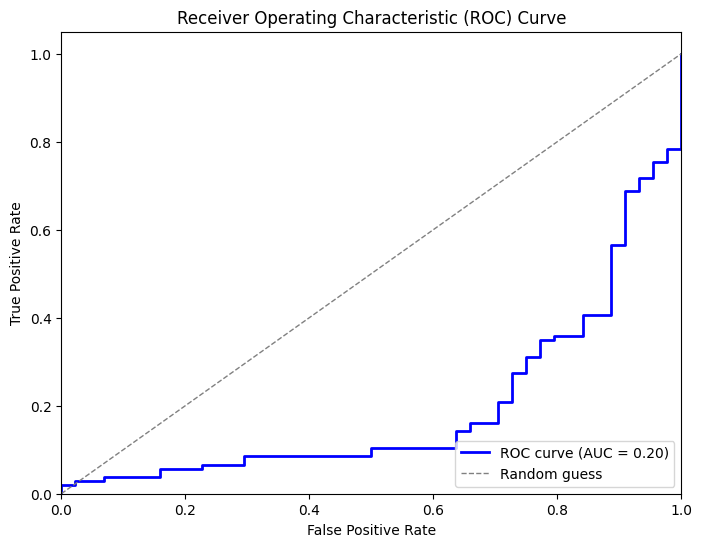

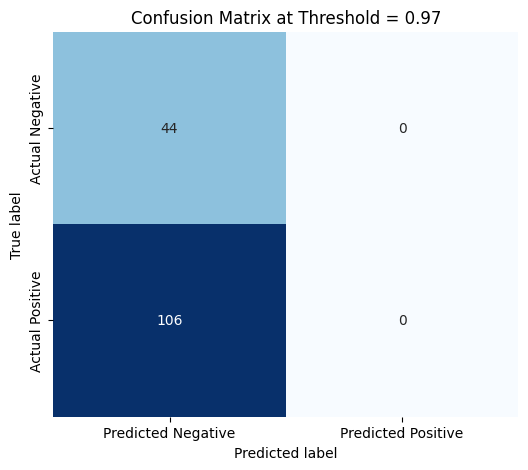

c:\Users\ADMIN\.conda\envs\bachelor-thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


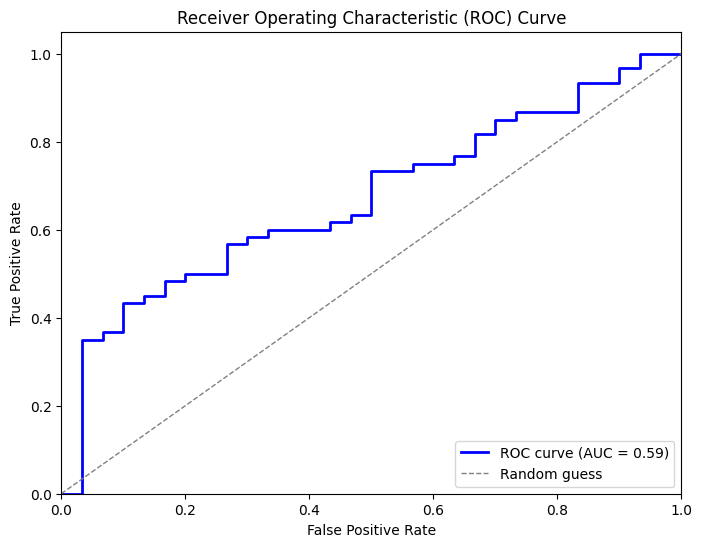

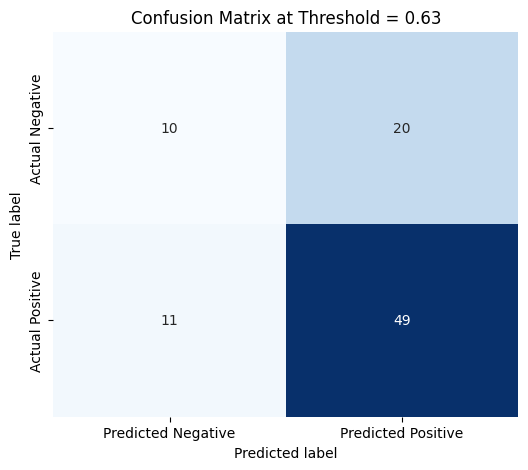

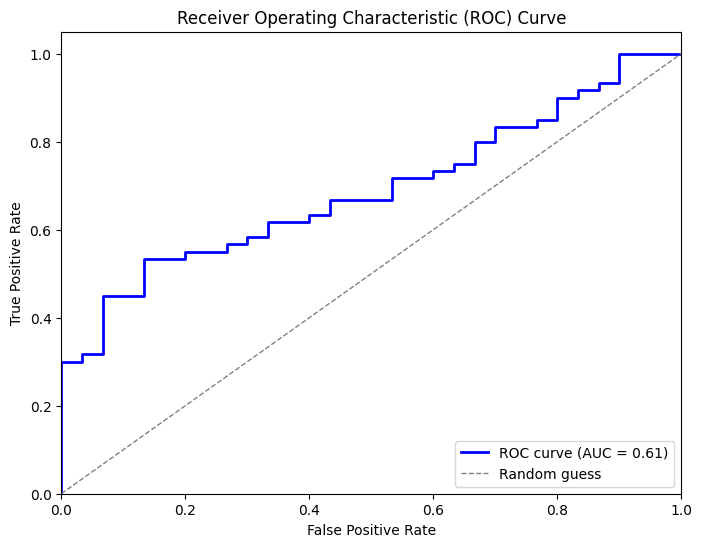

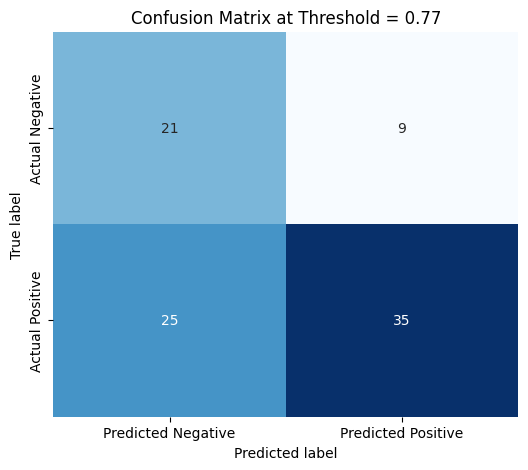

In [6]:
import json

res = {
    'books': get_evaluation_metrics(books),
    'halu_eval_long_answer': get_evaluation_metrics(halu_eval_long_answer),
    'halu_eval_long_answer_knowledge': get_evaluation_metrics(halu_eval_long_answer_knowledge),
}

with open('../data/output/interrogate_llm_zeroshot/evaluations.json', 'w', encoding='utf-8') as f:
    json.dump(res, f, indent=4)